In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.random import set_seed

from pandas_datareader.data import DataReader

import warnings
warnings.simplefilter("ignore")
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

set_seed(455)
np.random.seed(455)

2023-07-13 15:29:19.609559: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 15:29:20.184461: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Download Apple's stock market prices.

In [2]:
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download("AAPL", start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:
dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-07-13,24.352501,24.417500,24.209999,24.217501,22.361576,103568800
2016-07-14,24.347500,24.747499,24.330000,24.697500,22.804787,155676000
2016-07-15,24.730000,24.825001,24.625000,24.695000,22.802485,120548000
2016-07-18,24.674999,25.032499,24.650000,24.957500,23.044868,145975600
2016-07-19,24.889999,25.000000,24.834999,24.967501,23.054100,95119600
...,...,...,...,...,...,...
2023-07-06,189.839996,192.020004,189.199997,191.809998,191.809998,45094300
2023-07-07,191.410004,192.669998,190.240005,190.679993,190.679993,46778000
2023-07-10,189.259995,189.990005,187.039993,188.610001,188.610001,59922200


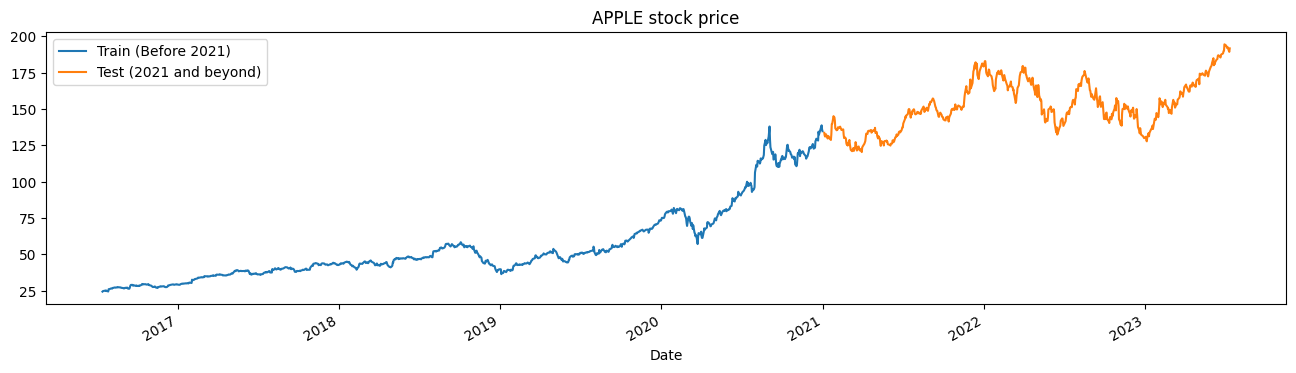

In [4]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("APPLE stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

In [5]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"]
    test = dataset.loc[f"{tend+1}":, "High"]
    return train, test

def train_test_split_values(dataset, tstart, tend):
    train, test =  train_test_split(dataset, tstart, tend)
    return train.values, test.values

training_set, test_set = train_test_split_values(dataset, tstart, tend)

In [6]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [7]:
def split_sequence(sequence, window):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + window
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

window_size = 60
features = 1

X_train, y_train = split_sequence(training_set_scaled, window_size)

In [8]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [9]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - window_size :].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [10]:
X_test, y_test = split_sequence(inputs, window_size)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
y_test = sc.inverse_transform(y_test)

# GRU

In [11]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(window_size, features)))
model_gru.add(Dense(units=1))

model_gru.compile(optimizer="adam", loss="mse")

model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 125)               48000     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 48126 (187.99 KB)
Trainable params: 48126 (187.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-07-13 15:29:21.501582: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-07-13 15:29:21.501624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: GHOSTMACHINE
2023-07-13 15:29:21.501631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: GHOSTMACHINE
2023-07-13 15:29:21.501750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.125.6
2023-07-13 15:29:21.501775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 470.199.2
2023-07-13 15:29:21.501782: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 470.199.2 does not match DSO version 525.125.6 -- cannot find working devices in this configuration
2023-0

In [12]:
model_gru.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
34/34 [==============================] - 2s 19ms/step - loss: 0.0180
Epoch 2/10
34/34 [==============================] - 1s 18ms/step - loss: 4.4560e-04
Epoch 3/10
34/34 [==============================] - 1s 18ms/step - loss: 2.6837e-04
Epoch 4/10
34/34 [==============================] - 1s 18ms/step - loss: 2.5386e-04
Epoch 5/10
34/34 [==============================] - 1s 19ms/step - loss: 2.5913e-04
Epoch 6/10
34/34 [==============================] - 1s 19ms/step - loss: 2.4525e-04
Epoch 7/10
34/34 [==============================] - 1s 18ms/step - loss: 2.4398e-04
Epoch 8/10
34/34 [==============================] - 1s 18ms/step - loss: 2.3246e-04
Epoch 9/10
34/34 [==============================] - 1s 17ms/step - loss: 2.2381e-04
Epoch 10/10
34/34 [==============================] - 1s 17ms/step - loss: 2.1620e-04


In [13]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

20/20 [==============================] - 0s 6ms/step


In [14]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

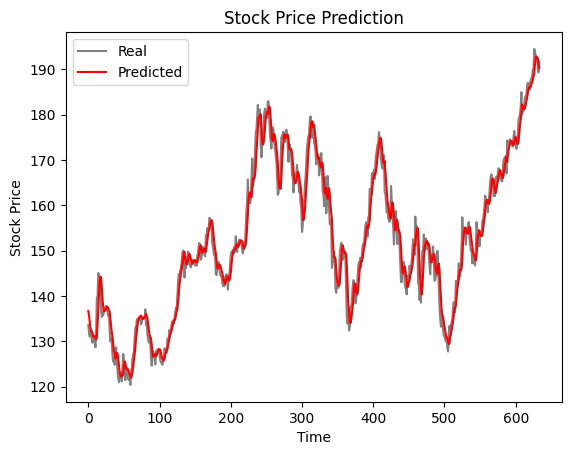

In [15]:
plot_predictions(y_test, GRU_predicted_stock_price)

In [16]:
def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

In [17]:
return_rmse(y_test,GRU_predicted_stock_price)

The root mean squared error is 3.13.
